# DS3. Kaggle 入门 (House Prices - Advanced Regression Techniques)

> - 本案例的数据库来自 Kaggle 的竞赛 [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)
> - 教程代码来自 [SERIGNE, Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard)


![](./pics/blue.png)

# 1. 概述

在项目开始之前，我们依然先使用常规步骤 （非 DS 科班，自己总结的，若有不对的地方请大佬指正）

1. 数据可视化，清洗和探索 (Vuslization, Cleaning and Exploration)
2. 特征工程和预处理 (Feature Engineering and Preprocessing)
3. 构建基准模型并交叉验证 (Build Baseline Models and Cross Validation)
4. 调整并整合模型 (Tuning and Ensemble)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
color = sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.shape

(1460, 81)

首先在简单查看数据集后我们发现，这个数据集中的列非常多，有81个，除去我们的目标值 `SalePrice` 还有 80 个数据特征。但给的训练数据量并不是很大，只有 1460 个。

![](./pics/green.png)

## 2. 可视化，清洗和探索

在深入探索之前我们已经大概的查看了一下数据集。其中，有一项 ID 列，即为每个数据的索引，这个对于我们的问题没有任何帮助，所以我们首先将这一列去掉。

In [4]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

之后我们将 `tain` 和 `test` 集合并，方便我们清洗数据和一些特征工程。

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


我们首先来简单的探索一下数据集中的数字类型列：

In [22]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
count,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,...,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000
mean,7.132,69.436,10139.439,0.996,0.986,1.948,0.054,6.086,4.565,1971.288,...,47.280,23.114,2.604,16.073,2.089,2.993,3.493,50.861,6.513,1.793
std,3.699,21.208,7807.037,0.064,0.260,1.410,0.249,1.407,1.113,30.287,...,67.119,64.263,25.197,56.202,34.561,0.127,1.092,567.595,2.984,1.315
min,0.000,21.000,1300.000,0.000,0.000,0.000,0.000,1.000,0.000,1872.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,5.000,60.000,7476.000,1.000,1.000,0.000,0.000,5.000,4.000,1953.000,...,0.000,0.000,0.000,0.000,0.000,3.000,4.000,0.000,5.000,1.000
50%,5.000,70.000,9452.000,1.000,1.000,3.000,0.000,6.000,4.000,1973.000,...,26.000,0.000,0.000,0.000,0.000,3.000,4.000,0.000,7.000,2.000
75%,10.000,80.000,11556.000,1.000,1.000,3.000,0.000,7.000,5.000,2001.000,...,70.000,0.000,0.000,0.000,0.000,3.000,4.000,0.000,9.000,3.000
max,15.000,313.000,215245.000,1.000,2.000,3.000,2.000,10.000,8.000,2010.000,...,742.000,1012.000,508.000,576.000,800.000,3.000,4.000,17000.000,11.000,4.000


> 该列表知乎无法显示因为列数太多了，共有 58 列。

我们需要预测的目标值为 `SalePrice`，即房屋价格。因此我们先对基于这个变量对数据集进行探索。

首先我们先画出

C:\Softwares\Anaconda\envs\DataScience\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180921.20 and sigma = 79415.29



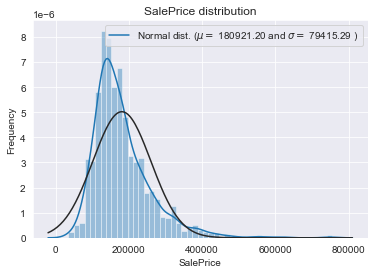

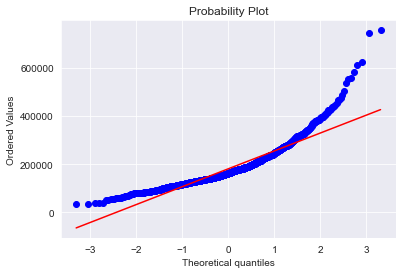

In [5]:
sns.distplot(train['SalePrice'] , fit=norm)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

画完上面的图后，我们发现价格的分布与理想的正态分布有一点差距，所以我们使用 `log` 将数据正则化。

C:\Softwares\Anaconda\envs\DataScience\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



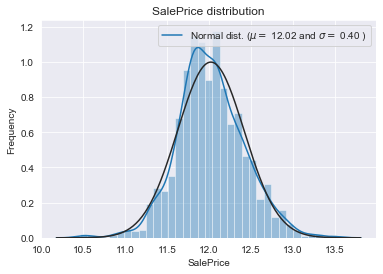

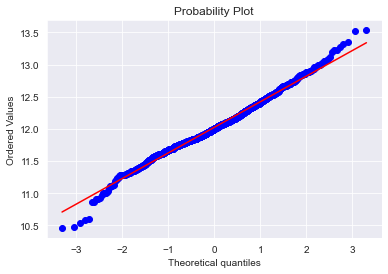

In [6]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

现在的数据分布得到了很好的修正。

接下来我们来查看价格的数据集中是否有 `outliers`，如果有就删掉这些数据。这里我们选用与房价成正相关的居住面积来检验。

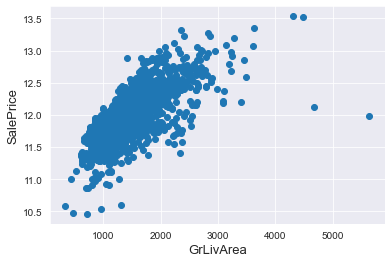

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

这里我们看到，有两个数据与其他数据相比偏离的很厉害，他们的房间面积大但价格却很低。这样的数据虽然真实存在，但对于我们的模型来说是不好的数据，所以要将他们删除掉。

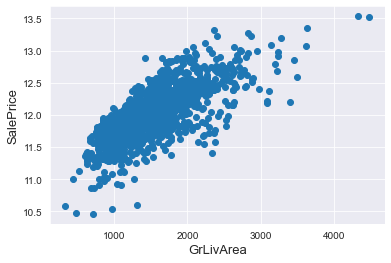

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

然后我们检查一下数据集中缺失的数据。并且找到前 20 个缺失数据最严重的列。

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

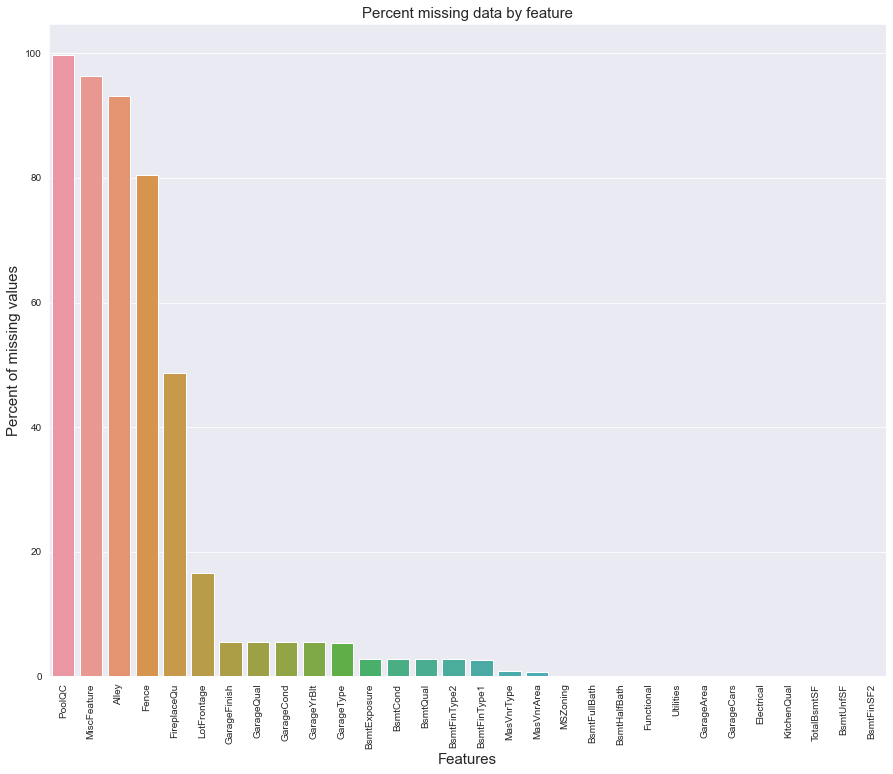

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

对于数据缺失太严重的列，我们需要先查看该列的具体情况，如果有填补的可能则尝试填补，否则我们需要考虑丢弃该列。而对于缺失数据较少的列，我们可以使用平均数或者中位数将该列补全。

下面我们来一一查看:

- **PoolQC**: 数据描述说 NA 表示“没有泳池”。这是有道理的，因为缺失值的比例很高（+99%），而且大多数房子一般都没有游泳池。
- **MiscFeature**: 数据描述说 NA 表示“没有杂项功能”。
- **Alley**: 数据描述说 NA 意味着“没有小巷访问”。
- **Fence**: 数据描述说 NA 表示“没有围栏”。
- **FireplaceQu**: 数据描述说NA的意思是“没有壁炉”。
- **LotFrontage**: 由于与房产相连的每条街道的面积很可能与附近其他房屋的面积相似，因此我们可以通过附近的 LotFrontage 中位数来填充缺失值。
- **GarageType, GarageFinish, GarageQual and GarageCond**: 用无替换缺失的数据。
- **GarageYrBlt, GarageArea and GarageCars**: 用 0 替换缺失的数据。
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: 由于没有地下室，缺失值可能为零。
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: 对于所有这些与地下室相关的分类特征，NaN 表示没有地下室。
- **MasVnrArea and MasVnrType**: NA 很可能意味着这些房屋没有砖石饰面。我们可以为区域填充 0，为类型填充无。
- **MSZoning**: 'RL' 是此列中最常见的值。所以我们可以用'RL'填充缺失值。
- **Utilities**: 对于这个分类特征，所有记录都是“AllPub”，除了一个“NoSeWa”和 2 个 NA 。由于带有“NoSewa”的房子在训练集中，这个特性对预测建模没有帮助。然后我们可以安全地删除它。
- **Functional**: 数据描述说 NA 表示典型。
- **Electrical**: 它有一个 NA 值。由于此功能主要具有“SBrkr”，因此我们可以将其设置为缺失值。
- **KitchenQual**: 只有一个 NA 值，与电气相同，我们为 KitchenQual 中的缺失值设置了“TA”（这是最常见的）。
- **Exterior1st and Exterior2nd**: 同样，外部 1 和 2 都只有一个缺失值。我们将只替换最常见的字符串。
- **SaleType**: 再次填写最频繁的“WD”。
- **MSSubClass**: Na 很可能意味着没有建筑等级。我们可以用 None 替换缺失值。

In [16]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

最后检查一下还有没有漏掉的：

In [17]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


这表示没有漏掉的数据了。

首先我们来查看一下列与列之间的相关性：

<AxesSubplot:>

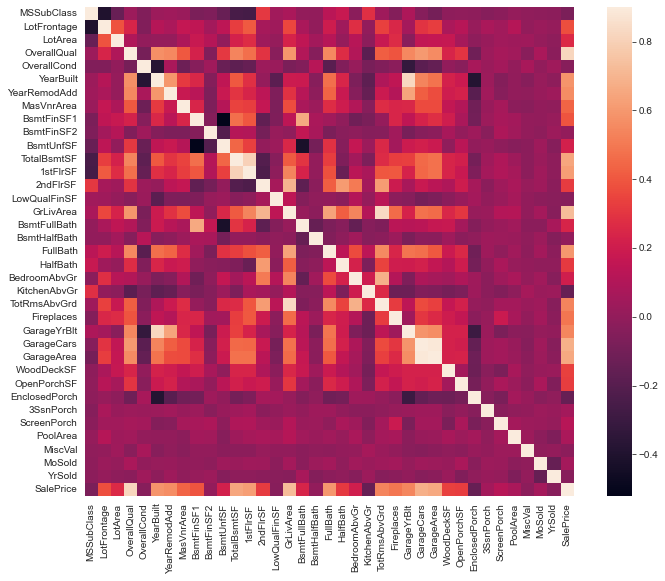

In [19]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

这里我们可以看出，一楼和二楼的面积正相关，车库面积和车库停车数量正相关，房间数量与居住面积正相关。

然后，将一些数字量转换为字符串的格式。

In [18]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

标签编码一些可能在其排序集中包含信息的分类变量

In [20]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


下面我们再检查一下分布偏移的特征。我们需要调整这些特征，因为他们会影响到我们模型的效果。

![分布偏移](./pics/skewed.jpeg)

> 关于为什么要这么做的具体解释 [Skewed Data: A problem to your statistical model](https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37)

In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


然后我们使用 Box cox 对高度偏移的特征进行修正。关于 [Sicpy.Boxcox1p](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html) 的描述

In [24]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 58 skewed numerical features to Box Cox transform


最后使用 One hot 编码的方法处理数据集。

In [25]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 219)


然后重现将数据集分为训练集和测试集用于建模

In [26]:
train = all_data[:ntrain]
test = all_data[ntrain:]

![](./pics/green.png)
## 3. 建模

In [27]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

C:\Softwares\Anaconda\envs\DataScience\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


这里我们使用的基础模型有：

- **LASSO Regression**：该模型可能对异常值非常敏感。所以我们需要让它对它们更加健壮。为此，我们在管道上使用 sklearn 的 Robustscaler() 方法。
- **Elastic Net Regression**：同样使用Robustscaler() 方法增加鲁棒性。
- **Kernel Ridge Regression**：
- **Gradient Boosting Regression**：使用 huber loss 使其对异常值具有鲁棒性。
- **XGBoost**：

我们使用交叉验证的方式测试这些模型，并打印出他们的分数。

In [39]:
#Validation function
n_folds = 5

def var_name(var,all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    print("\n{} score: {:.4f} ({:.4f})\n".format(var_name(model),rmse.mean(), rmse.std()))

In [40]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
rmsle_cv(lasso)
                                


lasso score: 0.1126 (0.0075)



In [41]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
rmsle_cv(ENet)


ENet score: 0.1126 (0.0076)



In [42]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
rmsle_cv(KRR)


KRR score: 0.1151 (0.0074)



In [43]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
rmsle_cv(GBoost)


GBoost score: 0.1177 (0.0081)



In [44]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
rmsle_cv(model_xgb)                             

[21:42:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:42:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:42:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings 

这里测试每个基础模型的效果都差不多，所有需要叠加模型。这里使用的是最基础的堆叠方法：平均基础模型。

下面我构建了一个新类来使用我们的模型扩展 scikit-learn，并且还可以进行封装和代码重用（继承）

In [45]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

我们在这里只对 ENet、GBoost、KRR 和 lasso 四个模型进行平均。当然，我们可以轻松地在组合中添加更多模型。

In [46]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

rmsle_cv(averaged_models)


averaged_models score: 0.1090 (0.0078)



这样简单的堆叠方法确实可以提高分数。以后通过尝试堆叠不同的模型，也许会有更好的效果。

当然，还有其他稍微复杂一点的堆叠方法：添加元模型。

在这种方法中，我们在平均基础模型上添加一个元模型，并使用这些基础模型的折叠预测来训练我们的元模型。

训练部分的过程可以描述如下：
- 将整个训练集分成两个不相交的集（这里是 train 和 .holdout ）
- 在第一部分训练几个基础模型（train）
- 在第二部分测试这些基本模型（holdout）
- 使用来自第三步的预测（称为 out-of-folds 预测）作为输入，使用正确的响应（目标变量）作为输出来训练更高级别的学习器，称为元模型。

前三个步骤是迭代完成的。 如果我们以 5 折堆叠为例，我们首先将训练数据分成 5 折。 然后我们将进行 5 次迭代。 在每次迭代中，我们在 4 个折叠上训练每个基本模型并预测剩余的折叠（保持折叠）。

因此，我们将确定，在 5 次迭代之后，整个数据都用于获得折叠预测，然后我们将在步骤 4 中将其用作新特征来训练我们的元模型。

对于预测部分，我们在测试数据上对所有基础模型的预测进行平均，并将它们用作元特征，在元特征上使用元模型完成最终预测。

![](./pics/QBuDOjs.jpg)

In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [48]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

rmsle_cv(stacked_averaged_models)


stacked_averaged_models score: 0.1084 (0.0076)



通过添加元学习器，我们再次获得了更好的分数。

最后集成 (Ensemble) StackedRegressor 和 XGBoost 的结果。因为之前处理数据的时候，房价被 log 修正过，所以在最后集成的时候需要使用 `np.expm1()` 还原。

In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [50]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07831985966000289


In [51]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[22:07:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Softwares\Anaconda\envs\DataScience\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.07897610033101468


In [55]:
ensemble = stacked_train_pred*0.8 + xgb_train_pred*0.2
print(rmsle(y_train, ensemble))

0.0769104451420249


我们最后得到的分数为 0.0769，这说明在训练集中，我们的模型表现的很好！当然最后还是要在测试集里检验，但这个检验需要提交到 Kaggle 才能得出结果。

- 上篇：[DS2. Kaggle 入门 (Titanic Project Example)](https://zhuanlan.zhihu.com/p/485780305)
- 下篇：[]()